#**1) EXPLORATIVE DATA ANALYSIS**

---


In [33]:
%%capture
!pip install -U spaCy
!python -m spacy download it_core_news_lg

In [34]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import string
import re
import requests
import random

# Graphics Libs
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 18, 8
import seaborn as sns
import matplotlib.colors as mcolors

# Pre-processing
import spacy
from spacy.lang.it import Italian
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# Gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from multiprocessing import cpu_count
import gensim.downloader as api
# Wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Models and utils
from sklearn.preprocessing import MinMaxScaler
# Tensorflow-keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
BASE_PATHS = [
    # Base paths for training
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_1/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_2/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_3/',

    # Base paths for testing
    'https://cdn.albertovalerio.com/datasets/dankmemes/1_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/2_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/3_test/'
]

IMAGES_PATHS = [
    # Images paths for training
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_1/images_task1_train/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_2/images_task2_train/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_3/images_task3_train/',

    # Images paths for testing
    'https://cdn.albertovalerio.com/datasets/dankmemes/1_test/1_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/2_test/2_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/3_test/3_test/'
]

FILENAMES = [
    # Files for training
    'dankmemes_task1_train.csv',
    'dankmemes_task2_train.csv',
    'dankmemes_task3_train.csv',
    'dankmemes_task1_train_embeddings.csv',
    'dankmemes_task2_train_embeddings.csv',
    'dankmemes_task3_train_embeddings.csv',

    # Files for testing
    'meme_test_final.csv',
    'hate_test_final.csv',
    'event_test_final.csv',
    '1_test_embeddings.csv',
    '2_test_embeddings.csv',
    '3_test_embeddings_fixed.csv',

    # Utils
    'italian-swear-words-list_comma-separated-text-file.txt'
]

In [36]:
task_1_train = pd.read_csv(BASE_PATHS[0] + FILENAMES[0])
task_2_train = pd.read_csv(BASE_PATHS[1] + FILENAMES[1])
task_3_train = pd.read_csv(BASE_PATHS[2] + FILENAMES[2])

task_1_test = pd.read_csv(BASE_PATHS[3] + FILENAMES[6])
task_2_test = pd.read_csv(BASE_PATHS[4] + FILENAMES[7])
task_3_test = pd.read_csv(BASE_PATHS[5] + FILENAMES[8])

In [37]:
task_1_train.head()

,File,Engagement,Date,Manipulation,Visual,Text,Meme
0,0.jpg,11,2019-08-12,1,Salvini,satira cruda votaci.. saremo di parola il part...,1
1,1.jpg,2261,2019-08-21,0,0,"peccato per le accise, dai. c'eravamo quasi.",0
2,2.jpg,1327,2019-08-23,0,"Salvini, Di Maio","""che c'è ancora?"" ""aspetto un bambino""",1
3,3.jpg,18,2019-08-27,0,0,ora in onda speciale gr1 ascolta la diretta se...,0
4,4.jpg,617,2019-08-25,0,"Salvini, Di Maio",sta sciocchezza che sto pe fa e solo colpa tua,1


In [38]:
task_2_train.head()

,File,Engagement,Manipulation,Visual,Text,Hate Speech
0,1000.jpg,381,0,0,quando ti chiedono se sia peggiore fratelli d'...,1
1,1001.jpg,142,1,0,conte entra in un negozio di telefonia e passa...,0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",i politicanti italici non vedono l'ora di anda...,1
3,1003.jpg,165,1,"Salvini, Renzi",sono scemo. io di più. scemo & più scemo,1
4,1004.jpg,44,0,0,"beppe grillo (2017) genova, 21 luglio 1948 pol...",0


In [39]:
task_3_train.head()

,File,Engagement,Date,Macro,Manipulation,Visual,Text,Event
0,2000.jpg,994,2019-05-09,0,1,Lega,suca salvini rosica,0
1,2001.jpg,20,2019-08-29,0,0,0,"in nome del popolo italiano, i cittadini itali...",0
2,2002.jpg,15,2016-07-08,0,0,0,"vladimir, ti interessa l'affare immigrati? asc...",0
3,2003.jpg,9,2019-08-29,0,0,"Meloni, Mattarella","""ma come chi sono? presidè sò io senza fotosci...",2
4,2004.jpg,12,2019-01-31,0,0,0,"cos'era? un topo di fogna? ah...no, salvini.",0


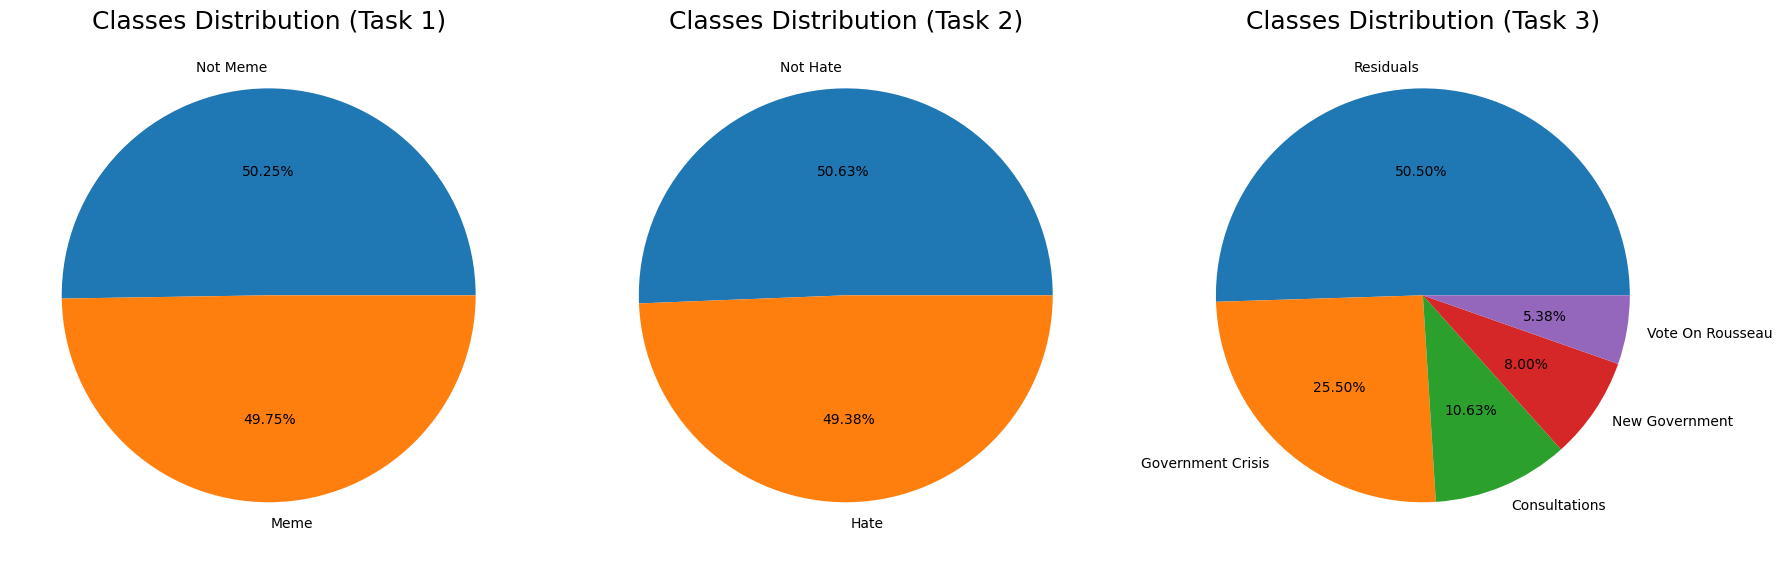

In [40]:
count1 = task_1_train['Meme'].value_counts()
count2 = task_2_train['Hate Speech'].value_counts()
count3 = task_3_train['Event'].value_counts()

labels1 = ['Not Meme', 'Meme']
labels2 = ['Not Hate', 'Hate']
labels3 = ['Residuals', 'Government Crisis', 'Consultations', 'New Government', 'Vote On Rousseau']

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 6))
ax1.pie(count1, labels=labels1, autopct = '%1.2f%%')
ax2.pie(count2, labels=labels2, autopct = '%1.2f%%')
ax3.pie(count3, labels=labels3, autopct = '%1.2f%%')
ax1.set_title('Classes Distribution (Task 1)', fontsize = 18)
ax2.set_title('Classes Distribution (Task 2)', fontsize = 18)
ax3.set_title('Classes Distribution (Task 3)', fontsize = 18)

plt.tight_layout()
plt.show()

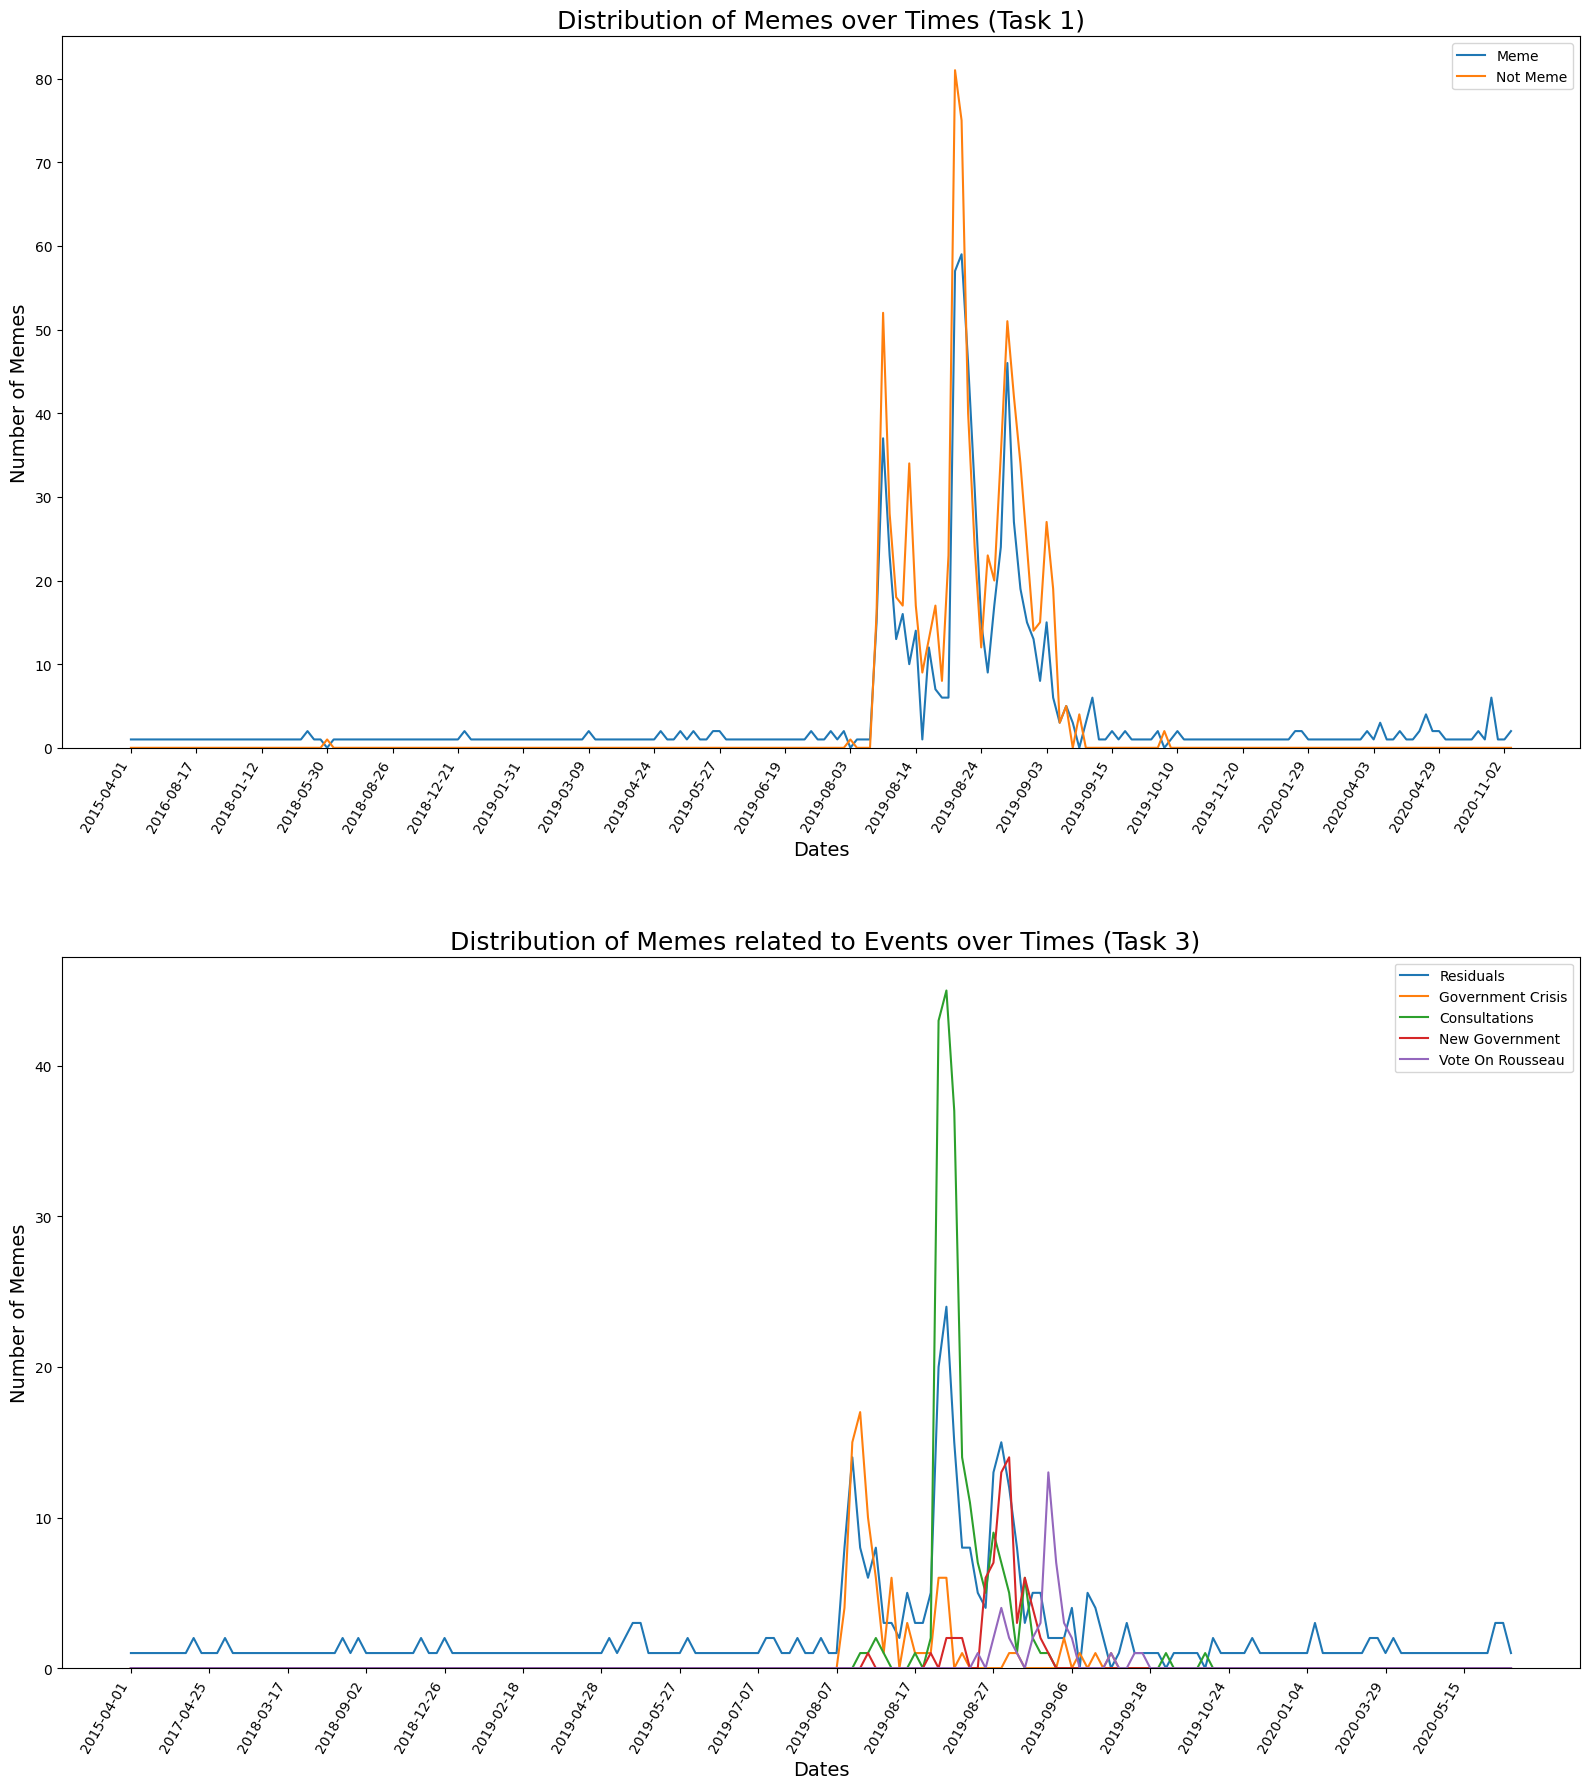

In [41]:
not_memes_by_date = task_1_train[task_1_train['Meme'] == 0].groupby('Date').size()
memes_by_date = task_1_train[task_1_train['Meme'] == 1].groupby('Date').size()
df1 = pd.DataFrame(index=pd.concat([not_memes_by_date, memes_by_date], axis=1).index, columns=['Meme','Not Meme'])
df1.loc[not_memes_by_date.index, 'Not Meme'] = not_memes_by_date.values
df1.loc[memes_by_date.index, 'Meme'] = memes_by_date.values
df1 = df1.sort_index()
df1 = df1.fillna(0)

class_0_by_date = task_3_train[task_3_train['Event'] == 0].groupby('Date').size()
class_1_by_date = task_3_train[task_3_train['Event'] == 1].groupby('Date').size()
class_2_by_date = task_3_train[task_3_train['Event'] == 2].groupby('Date').size()
class_3_by_date = task_3_train[task_3_train['Event'] == 3].groupby('Date').size()
class_4_by_date = task_3_train[task_3_train['Event'] == 4].groupby('Date').size()
df2 = pd.DataFrame(index=pd.concat([class_0_by_date, class_1_by_date, class_2_by_date, class_3_by_date, class_4_by_date], axis=1).index,
                   columns=['Residuals', 'Government Crisis', 'Consultations', 'New Government', 'Vote On Rousseau'])
df2.loc[class_0_by_date.index, 'Residuals'] = class_0_by_date.values
df2.loc[class_1_by_date.index, 'Government Crisis'] = class_1_by_date.values
df2.loc[class_2_by_date.index, 'Consultations'] = class_2_by_date.values
df2.loc[class_3_by_date.index, 'New Government'] = class_3_by_date.values
df2.loc[class_4_by_date.index, 'Vote On Rousseau'] = class_4_by_date.values
df2 = df2.sort_index()
df2 = df2.fillna(0)


fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(16, 18))
ax1.plot(df1.index, df1['Meme'], label='Meme')
ax1.plot(df1.index, df1['Not Meme'], label='Not Meme')
ax1.set_xlabel('Dates', fontsize = 14)
ax1.set_ylabel('Number of Memes', fontsize = 14)
ax1.set_xticks([df1.index[i] for i in range(0,len(df1.index),10)])
ax1.set_xticklabels([df1.index[i] for i in range(0,len(df1.index),10)], rotation = 60, ha="right")
ax1.set_ylim(ymin=0)
ax1.legend(loc='upper right')
ax1.set_title('Distribution of Memes over Times (Task 1)', fontsize = 18)
ax2.plot(df2.index, df2['Residuals'], label='Residuals')
ax2.plot(df2.index, df2['Government Crisis'], label='Government Crisis')
ax2.plot(df2.index, df2['Consultations'], label='Consultations')
ax2.plot(df2.index, df2['New Government'], label='New Government')
ax2.plot(df2.index, df2['Vote On Rousseau'], label='Vote On Rousseau')
ax2.set_xlabel('Dates', fontsize = 14)
ax2.set_ylabel('Number of Memes', fontsize = 14)
ax2.set_xticks([df2.index[i] for i in range(0,len(df2.index),10)])
ax2.set_xticklabels([df2.index[i] for i in range(0,len(df2.index),10)], rotation = 60, ha="right")
ax2.set_ylim(ymin=0)
ax2.legend(loc='upper right')
ax2.set_title('\n\n Distribution of Memes related to Events over Times (Task 3)', fontsize = 18)

plt.tight_layout()
plt.show()

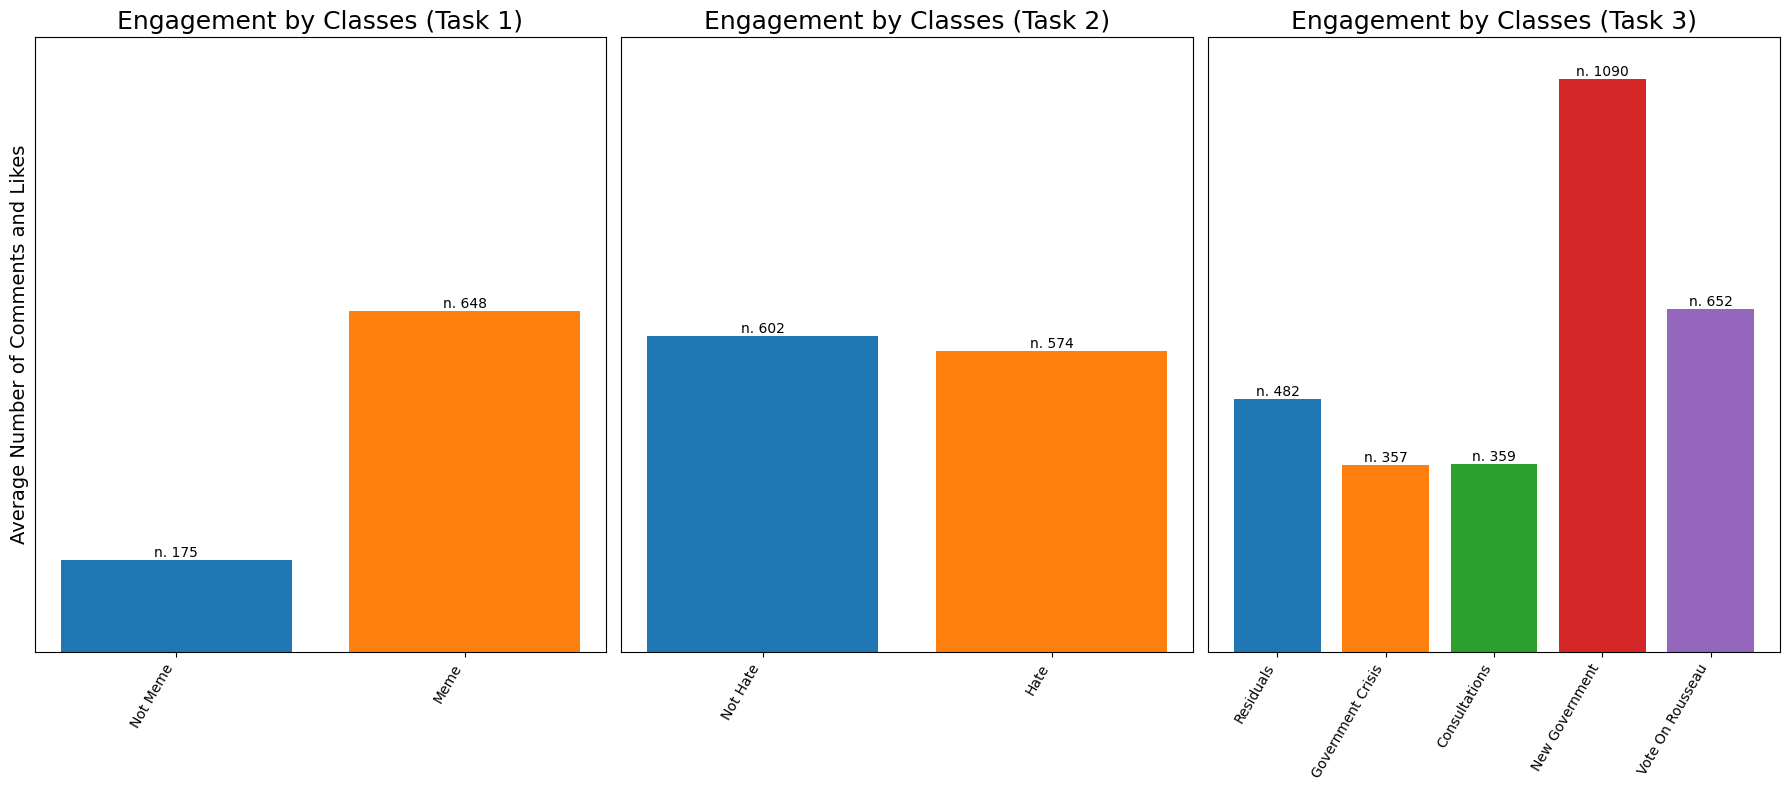

In [42]:
height1 = [
    task_1_train[task_1_train['Meme'] == 0]['Engagement'].mean(),
    task_1_train[task_1_train['Meme'] == 1]['Engagement'].mean()
]
height2 = [
    task_2_train[task_2_train['Hate Speech'] == 0]['Engagement'].mean(),
    task_2_train[task_2_train['Hate Speech'] == 1]['Engagement'].mean()
]
height3 = [
    task_3_train[task_3_train['Event'] == 0]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 1]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 2]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 3]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 4]['Engagement'].mean(),
]

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 8))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.bar(labels1, height=height1, color=colors)
ax1.set_ylabel('Average Number of Comments and Likes', fontsize = 14)
for rect in bars1:
     height = rect.get_height()
     ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')
bars2 = ax2.bar(labels2, height=height2, color=colors)
for rect in bars2:
     height = rect.get_height()
     ax2.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')
bars3 = ax3.bar(labels3, height=height3, color=colors)
for rect in bars3:
     height = rect.get_height()
     ax3.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax1.set_title('Engagement by Classes (Task 1)', fontsize = 18)
ax2.set_title('Engagement by Classes (Task 2)', fontsize = 18)
ax3.set_title('Engagement by Classes (Task 3)', fontsize = 18)
ax1.set_ylim(ymin=0, ymax=(max(height3)+80))
ax2.set_ylim(ymin=0, ymax=(max(height3)+80))
ax3.set_ylim(ymin=0, ymax=(max(height3)+80))
ax1.set_xticklabels(labels1, rotation = 60, ha="right")
ax2.set_xticklabels(labels2, rotation = 60, ha="right")
ax3.set_xticklabels(labels3, rotation = 60, ha="right")
plt.tight_layout()
plt.show()

#**2) PRE-PROCESSING**

---


In [43]:
punctuations = string.punctuation
nlp = spacy.load("it_core_news_lg")
stop_words = stopwords.words('italian')

r = requests.get(BASE_PATHS[1] + FILENAMES[12])
swear_words = r.content.decode()

In [44]:
def my_preprocessing(sentence, hashtag=False, explicit=True, lemmatization=True):

    #1 Normalization
    if hashtag:
        sentence = ' '.join(re.sub("@\w+|#\w+", "", sentence).split())

    if explicit:
        matches = re.findall('\w+\*+\w+|\w+x+\w+', sentence)
        for m in matches:
            sentence = sentence.replace(m, get_explicit(m))

    #2 Tokenization
    tokens = nlp(sentence)

    #3 Cleaning (removing punctuation and stop words)
    tokens = [ word.text for word in tokens ]
    tokens = [ word for word in tokens if word not in stop_words and word not in punctuations and "." not in word and "'" not in word ]
    tokens = [ word for word in tokens if len(word) > 2]

    #4 Lemmatization
    if lemmatization:
        tokens = [w.lemma_.lower() for w in nlp(' '.join(tokens))]

    return tokens

In [45]:
# This function convert a user censored bad word (i.e. "sei una m***a")
# with an equivalent one taken from a list of italian bad words
# according to the same initial and final uncesored letters and to the same POS tag (where possible!)
def get_explicit(censored):
    explicit = ''
    start = censored.split('*')[0] if '*' in censored else censored.split('x')[0]
    end = censored.split('*')[-1] if '*' in censored else censored.split('x')[-1]
    pattern = '\\b, '+start+'[a-z]*'+end+'\\b'
    all = ' '.join([w[2:] for w in re.findall(pattern, swear_words)])
    if all:
        options = [o for o in nlp(all)]
        options_tag_check = [o for o in nlp(all) if o.tag_ is nlp(censored)[0].tag_]
        if len(options_tag_check):
            explicit = random.choice(options_tag_check).text
        else:
            explicit = random.choice(options).text
    return explicit

In [46]:
for i in task_2_train.sample(n=10)['Text']:
    print(f'{"ORIGINAL:":<20}{i}')
    print(f'{"PROCESSED:":<20}{my_preprocessing(i)}')
    print(f'{"NO_LEMMATIZATION:":<20}{my_preprocessing(i, lemmatization=False)}')
    print('\n')

ORIGINAL:           mi sono iscritto al movimento 5 stelle per combattere il sistema com'è andata? m'è arrivata a casa la tessera del pd
PROCESSED:          ['iscrivere', 'movimento', 'stella', 'combattere', 'sistema', 'andare', 'arrivare', 'casa', 'tesserare']
NO_LEMMATIZATION:   ['iscritto', 'movimento', 'stelle', 'combattere', 'sistema', 'andata', 'arrivata', 'casa', 'tessera']


ORIGINAL:           coglionavirus
PROCESSED:          ['coglionavirus']
NO_LEMMATIZATION:   ['coglionavirus']


ORIGINAL:           what the fuck is pd doing? his best
PROCESSED:          ['what', 'the', 'fuck', 'doing', 'his', 'best']
NO_LEMMATIZATION:   ['what', 'the', 'fuck', 'doing', 'his', 'best']


ORIGINAL:           "situazione molto difficile". per le consultazioni mattarella chiede 100 euro a seduta
PROCESSED:          ['situazione', 'molto', 'difficile', 'consultazione', 'mattarella', 'chiedere', '100', 'euro', 'sedere']
NO_LEMMATIZATION:   ['situazione', 'molto', 'difficile', 'consultazioni', 'm

#**3) FEATURES EXTRACTION**

---


In [47]:
data = task_2_train

## **Text Processed**

In [48]:
data['Tokens'] = data['Text'].apply(lambda x:' '.join(my_preprocessing(x)))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Text', 'Tokens', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Text,Tokens,Hate Speech
616,1616.jpg,347,0,Salvini,elezioni subito. attaccate ar cazzo. ar cazzo ...,elezione subito attaccare cazzo cazzo dovere a...,1
427,1427.jpg,4,1,"Conte, Salvini",si fermi presidente è già morto,fermo presidente già morire,0
302,1302.jpg,91,0,"Salvini, Conte",ma quindi così senza vaselina? eh sì,quindi così senza vaselina,1
33,1033.jpg,366,1,"Salvini, Conte",sindaco di turno che spiega che lo stadio non ...,sindaco turno spiegare stadio priorità,0
716,1716.jpg,121,0,Salvini,scientificamente provato. fissare questa immag...,scientificamente provare fissare immagine seco...,1
657,1657.jpg,864,1,0,quando si apre la crisi di governo e la possib...,quando aprire crisi governo possibilità salvin...,0
247,1247.jpg,41,0,0,end world hunger. end world poverty. end salvi...,end world hunger end world poverty end salvini...,1
180,1180.jpg,12,0,Meloni,governo pd - m5s 100% in olio d'ulivo,governo m5s 100 olio ulivo,0
322,1322.jpg,7,0,"Conte, Salvini","..quasta volta lo devo dire, devo fare nome e ...",quastare volta dovere dire dovere fare nome co...,1
650,1650.jpg,190,1,Salvini,trovata opera inedita di modigliani intitolata...,trovare opera inedito modigliani intitolare co...,1


## **Word Cloud**

In [68]:
hateful_meme_tokens = data[data['Hate Speech']==1]['Tokens'].tolist()
nonhateful_meme_tokens = data[data['Hate Speech']==0]['Tokens'].tolist()

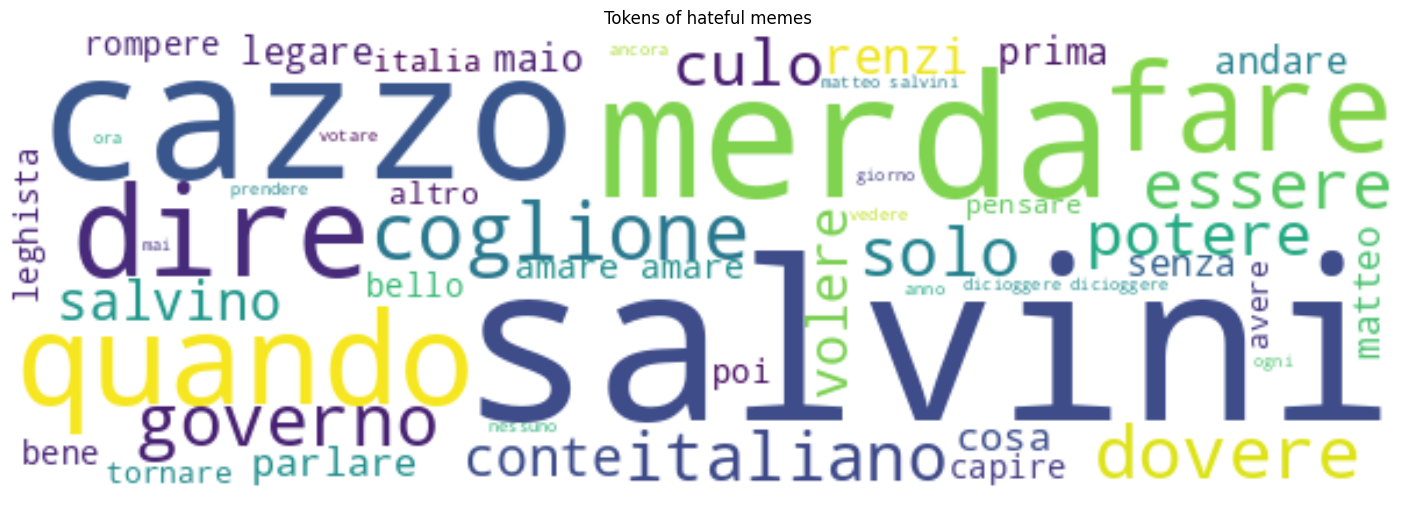

In [67]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(hateful_meme_tokens))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Tokens of hateful memes")
plt.show()

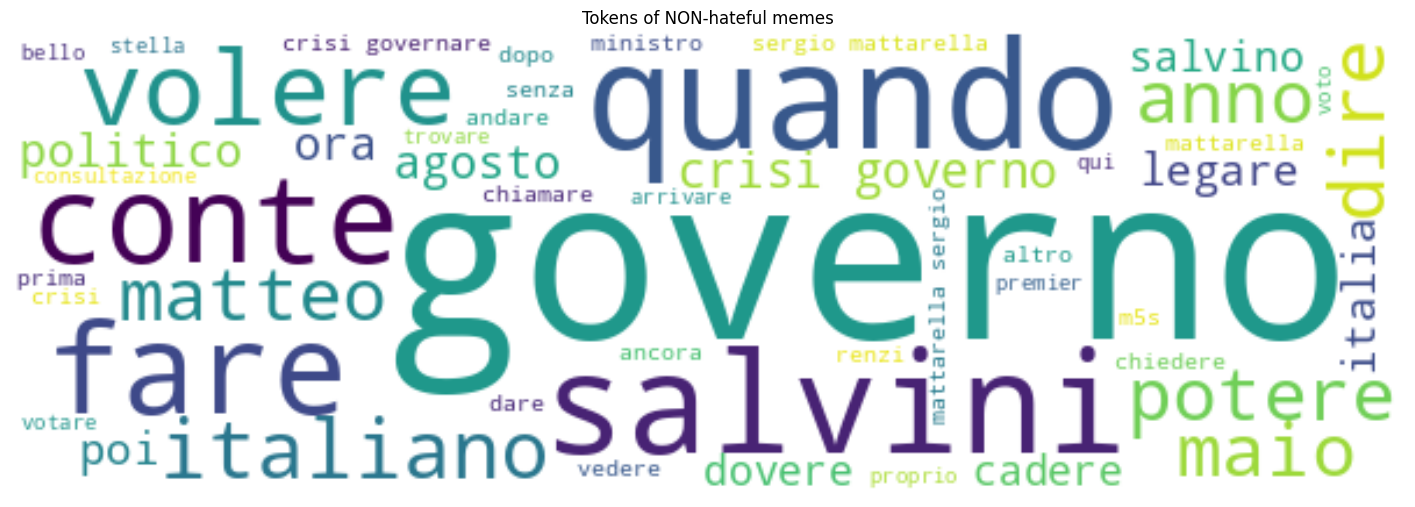

In [69]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(nonhateful_meme_tokens))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Tokens of NON-hateful memes")
plt.show()

## **Hate Score**

The hate score is given by the difference between the number of hate meme and the number of not hate meme for each of the people in 'Visual' column.

In [50]:
visuals = task_2_train['Visual']
people = []
for i in visuals:
    s = i.split(',')
    s = [j.strip() for j in s if j != ' ' and j != '']
    for e in s:
        if (e is not '0' and e.title() not in people):
            people.append(e.title())

df3 = pd.DataFrame(index=[p.title() for p in people], columns=['Hate Meme','Not Hate Meme','Hate Score'])
for p in people:
    all_by_person = task_2_train[task_2_train['Visual'].str.contains(p, case=False)]
    df3.loc[p, 'Hate Meme'] = 0-len(all_by_person[task_2_train['Hate Speech'] == 1])
    df3.loc[p, 'Not Hate Meme'] = len(all_by_person[task_2_train['Hate Speech'] == 0])
    df3.loc[p, 'Hate Score'] = len(all_by_person[task_2_train['Hate Speech'] == 0]) - len(all_by_person[task_2_train['Hate Speech'] == 1])

df3 = df3.sort_values('Hate Score')
df3.sample(n=10)

,Hate Meme,Not Hate Meme,Hate Score
Zingaretti,-6,15,9
Casalino,-3,1,-2
Santanchè,-1,0,-1
Grillo,-3,4,1
Toninelli,-2,0,-2
Di Maio,-42,71,29
Fico,-2,2,0
Renzi,-23,16,-7
Cuperlo,-1,0,-1
Bossi,-1,0,-1


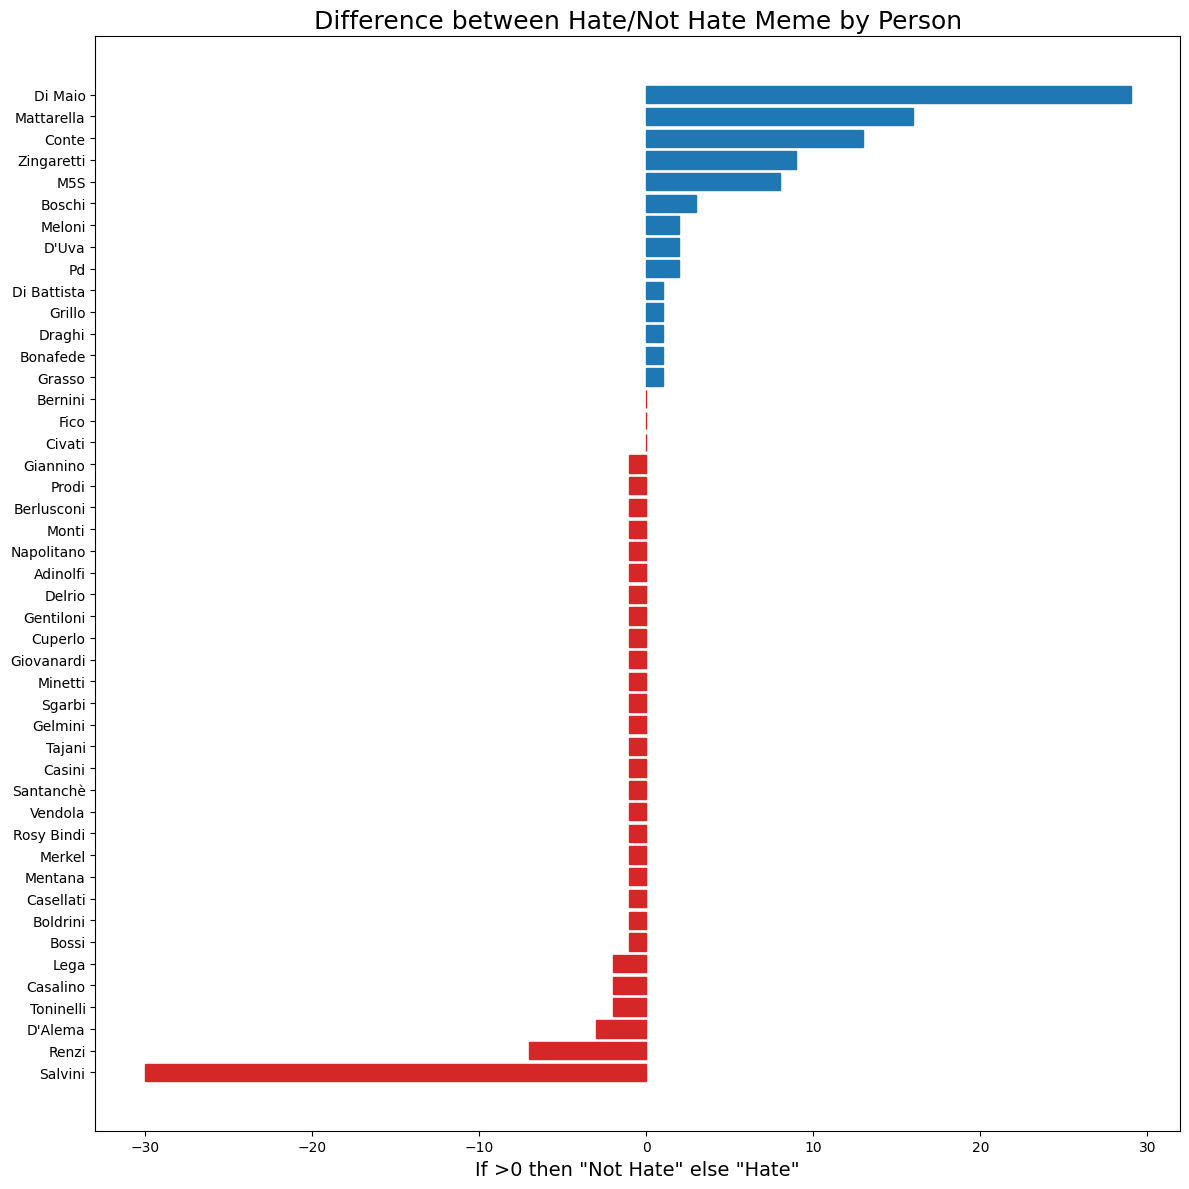

In [51]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.barh(df3.index, width=df3['Hate Score'], color=colors)
ax1.set_xlabel('If >0 then "Not Hate" else "Hate"', fontsize = 14)
for rect in bars1:
    width = rect.get_width()
    if (width > 0):
        rect.set_color('tab:blue')
    else:
        rect.set_color('tab:red')

ax1.set_title('Difference between Hate/Not Hate Meme by Person', fontsize = 18)
plt.tight_layout()
plt.show()

In [52]:
# The hate score is given by the difference between the number of 
# hate meme and the number of not hate meme for each of the people in 'Visual' column
def get_hate_score(visual, score_df):
    score = np.NAN
    if (visual != '0'):
        visual = visual.split(',')
        visual = [j.strip().title() for j in visual if j != ' ' and j != '' and j != '0']
        score = score_df.loc[visual, 'Hate Score'].sum()
    return score

data['Hate Score'] = data['Visual'].apply(lambda x:get_hate_score(x, df3))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Hate Speech
672,1672.jpg,388,0,"Salvini, Mattarella",-14.0,"c'era il 3x2 sugli abiti uomo da oviesse, eh...?",abito uomo oviere,0
171,1171.jpg,8,0,0,NaN,... e concludo con hashtag #salvinimerda,concludo hashtag salvinimerda,1
566,1566.jpg,83,1,Di Maio,29.0,retromarcia sulla tav decreto sicurezza bis re...,retromarcia tav decreto sicurezza bis regalare...,0
609,1609.jpg,105,0,0,NaN,oggi parleremo di come matteo salvini si è inc...,oggi parlare matteo salvini inculare solo medi...,1
272,1272.jpg,3,0,0,NaN,"dopo il bianco conte, la parola all'augusto sa...",dopo bianco conte parolare augusto salvini,0
155,1155.jpg,10,0,Salvini,-30.0,quando sei in calo nei sondaggi e decidi di ta...,quando calo sondaggio decidi tagliare ti barba...,1
372,1372.jpg,181,1,0,NaN,quando provi a votare su rousseau ma il sito n...,quando provare votare rousseau sito carico,0
230,1230.jpg,6,1,Di Maio,29.0,e la luna rousseau,luna rousseau,0
464,1464.jpg,1,0,0,NaN,crisi di governo: salvini un attimo prima e un...,crisi governare salvini attimo prima attimo dopo,0
18,1018.jpg,11,0,Salvini,-30.0,anime opening,anima opening,0


## **Number of Words**

The number of words calculated for the original 'Text' column's data.

In [53]:
data['Nr Words Text'] = data['Text'].apply(lambda x:len(str(x).split()))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words Text', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words Text,Hate Speech
114,1114.jpg,13,1,0,NaN,"ah shit, here we go again",shit here again,6,1
351,1351.jpg,2,1,Di Maio,29.0,di maio vuole fare il ministro dell'interno !,maio volere fare ministro interno,8,0
330,1330.jpg,34,1,"Conte, Salvini",-17.0,"49 milioni di rubli bacioni crisi, conte: ""sal...",milione rubli bacione crisi conte salvini dire...,29,0
163,1163.jpg,35,1,Salvini,-30.0,@milanonobile carlo hebdo,@milanonobile carlo hebdo,3,0
241,1241.jpg,2,0,Mattarella,16.0,"breaking news mattarella: ""andate a fanculo"" m...",breaking news mattarella andare fanculo mattar...,20,1
387,1387.jpg,221,1,"Di Maio, Conte",42.0,quando tua mamma sta cazziando tuo fratello e ...,quando mamma cazziare fratello rimanare silenz...,20,1
525,1525.jpg,59,0,Salvini,-30.0,"italia, 4 settembre 2019 un disoccupato attent...",italia settembre 2019 disoccupato attento aper...,22,0
208,1208.jpg,128,0,Sgarbi,-1.0,"hai preso un sacco di like con i meme, non rom...",prendere sacco like meme rompere coglione,13,1
603,1603.jpg,8,0,0,NaN,"uff! meno male, pensavo dicesse il negro con l...",uff meno male pensare dicere negro dividere po...,22,1
42,1042.jpg,9,0,0,NaN,mi scusi signora questo posto è riservato ai d...,scusi signore posto riservato disabile comunis...,16,1


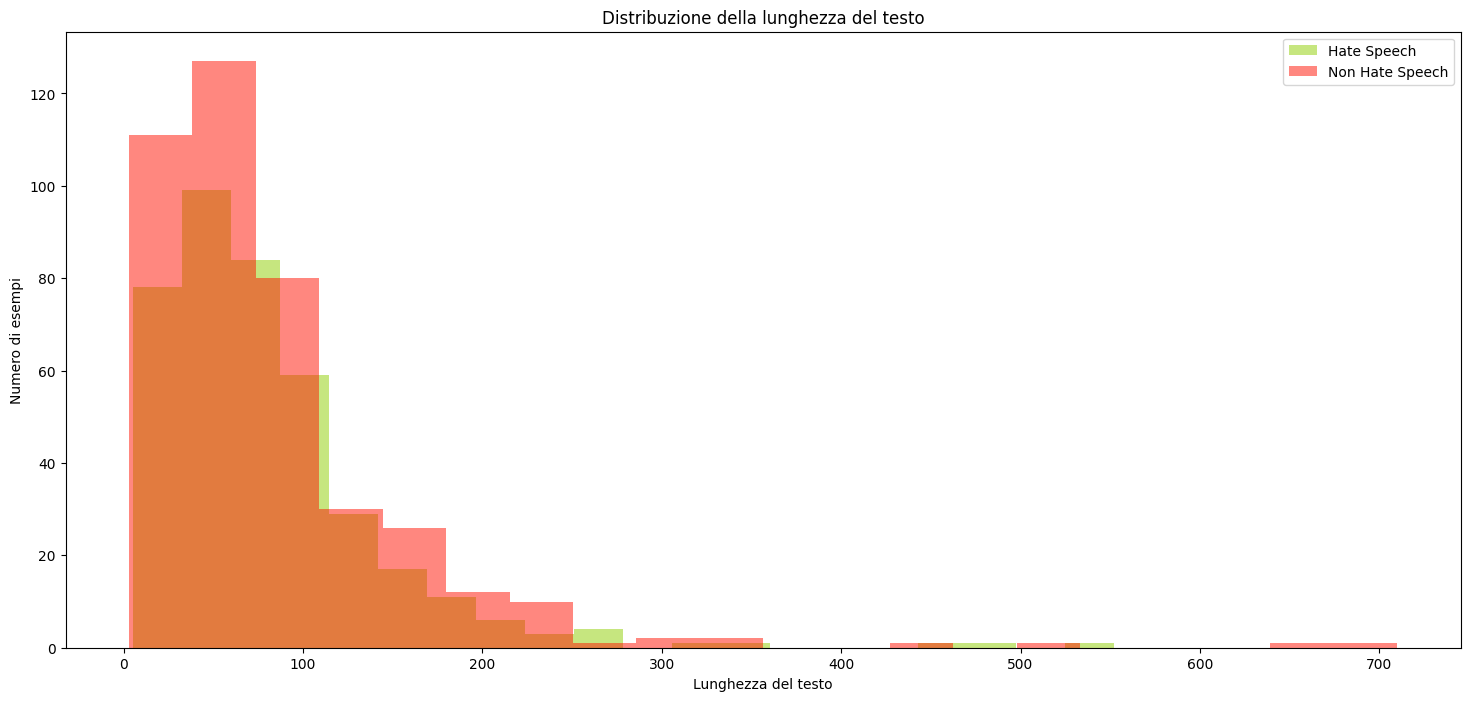

In [54]:
# Visualizzo la lunghezza del testo dei meme e delle immagini che non sono meme
# Filtra il dataset per i valori con meme = 1
meme_dataset = data[data['Hate Speech'] == 1]
non_meme_dataset = data[data['Hate Speech'] == 0]

# Calcola la lunghezza del testo per i valori con meme = 1
meme_dataset['Nr Words Text'] = meme_dataset['Text'].apply(len)
non_meme_dataset['Nr Words Text'] = non_meme_dataset['Text'].apply(len)

# Crea il plot della lunghezza del testo per meme e non meme
plt.hist(meme_dataset['Nr Words Text'], bins=20, alpha=0.5, label='Hate Speech', color='#8fce00')
plt.hist(non_meme_dataset['Nr Words Text'], bins=20, alpha=0.5, label='Non Hate Speech', color='#ff1100')
plt.xlabel('Lunghezza del testo')
plt.ylabel('Numero di esempi')
plt.title('Distribuzione della lunghezza del testo')
plt.legend()
plt.show()

## **NER**

In [55]:
tokens = data['Tokens']
df4 = pd.DataFrame(columns=['File Id','Entity Name','Entity Label'])
for t in tokens:
    spacy_tokens = nlp(t)
    if spacy_tokens.ents:
        names = []
        labels = []
        for ent in spacy_tokens.ents:
            names.append(ent.text)
            labels.append(ent.label_)
        list_row = [data[data['Tokens'] == t]['File'].iat[0], ', '.join(names), ', '.join(labels)]
        df4.loc[len(df4)] = list_row

df4.sample(n=10)

,File Id,Entity Name,Entity Label
128,1268.jpg,salvini,PER
63,1127.jpg,problems stress pain maratona,MISC
56,1111.jpg,vladimir,PER
131,1274.jpg,sinistra manco pippe,LOC
306,1621.jpg,villanovaforru vieni,PER
84,1172.jpg,error,MISC
139,1287.jpg,parolere ordine agente dana,MISC
250,1508.jpg,salvini,PER
243,1495.jpg,sciacallo,LOC
130,1272.jpg,augusto salvini,PER


## **Words Embedding**

In [56]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data['Tokens'])]
d2v = Doc2Vec(vector_size=400, window=2, min_count=1)
d2v.build_vocab(documents)

In [57]:
data['Doc2Vec'] = data['Tokens'].apply(lambda x: d2v.infer_vector(x.split()))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Doc2Vec', 'Nr Words Text', 'Hate Speech']]
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Doc2Vec,Nr Words Text,Hate Speech
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,"[0.0011870415, -0.0006288655, -0.00033381424, ...",15,1
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,"[-0.0009713581, -0.0011700058, 0.0001572068, -...",14,0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,"[-0.0011275735, -0.0007243308, 0.00020176829, ...",17,1
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,"[-7.0739094e-05, 9.253815e-05, 0.00043082624, ...",9,1
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,"[0.0006772129, 0.0006834714, -0.0009814687, -0...",26,0


#**4) MODEL DEFINITION**

---


## **Create final dataset with image embeddings**

In [58]:
task_2_embeddings = pd.read_csv(BASE_PATHS[1] + FILENAMES[4], header=None)
task_2_embeddings.head()

,0,1
0,1000.jpg,0.03371752053499222 0.7138307690620422 0.16221...
1,1001.jpg,0.017445266246795654 0.016754239797592163 0.06...
2,1002.jpg,0.2331690937280655 2.1796271800994873 0.0 0.00...
3,1003.jpg,0.09365507960319519 1.8714182376861572 0.52478...
4,1004.jpg,0.1272037923336029 1.260957956314087 0.1069836...


In [59]:
data['Image_embeddings'] = task_2_embeddings.loc[:][1]

def convert_to_float_list(string):
  values = string.split()
  for i in range(0, len(values)):
    values[i] = float(values[i])

    return values

data['Image_embeddings_float'] = np.array(data['Image_embeddings'].apply(convert_to_float_list))
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Doc2Vec,Nr Words Text,Hate Speech,Image_embeddings,Image_embeddings_float
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,"[0.0011870415, -0.0006288655, -0.00033381424, ...",15,1,0.03371752053499222 0.7138307690620422 0.16221...,"[0.03371752053499222, 0.7138307690620422, 0.16..."
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,"[-0.0009713581, -0.0011700058, 0.0001572068, -...",14,0,0.017445266246795654 0.016754239797592163 0.06...,"[0.017445266246795654, 0.016754239797592163, 0..."
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,"[-0.0011275735, -0.0007243308, 0.00020176829, ...",17,1,0.2331690937280655 2.1796271800994873 0.0 0.00...,"[0.2331690937280655, 2.1796271800994873, 0.0, ..."
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,"[-7.0739094e-05, 9.253815e-05, 0.00043082624, ...",9,1,0.09365507960319519 1.8714182376861572 0.52478...,"[0.09365507960319519, 1.8714182376861572, 0.52..."
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,"[0.0006772129, 0.0006834714, -0.0009814687, -0...",26,0,0.1272037923336029 1.260957956314087 0.1069836...,"[0.1272037923336029, 1.260957956314087, 0.1069..."


Scaling delle colonne numeriche

In [60]:
scaler = MinMaxScaler()

data['Engagement'] = scaler.fit_transform(data['Engagement'].values.reshape(-1, 1))
data['Nr Words Text'] = scaler.fit_transform(data['Nr Words Text'].values.reshape(-1, 1))

# replace Nan values with 0
data['Hate Score'] = data['Hate Score'].fillna(0)
data['Hate Score'] = scaler.fit_transform(data['Hate Score'].values.reshape(-1, 1))
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Doc2Vec,Nr Words Text,Hate Speech,Image_embeddings,Image_embeddings_float
0,1000.jpg,0.009771,0,0,0.385417,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,"[0.0011870415, -0.0006288655, -0.00033381424, ...",0.115702,1,0.03371752053499222 0.7138307690620422 0.16221...,"[0.03371752053499222, 0.7138307690620422, 0.16..."
1,1001.jpg,0.003642,1,0,0.385417,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,"[-0.0009713581, -0.0011700058, 0.0001572068, -...",0.107438,0,0.017445266246795654 0.016754239797592163 0.06...,"[0.017445266246795654, 0.016754239797592163, 0..."
2,1002.jpg,0.092271,1,"Di Maio, Zingaretti, Berlusconi, Salvini",0.458333,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,"[-0.0011275735, -0.0007243308, 0.00020176829, ...",0.132231,1,0.2331690937280655 2.1796271800994873 0.0 0.00...,"[0.2331690937280655, 2.1796271800994873, 0.0, ..."
3,1003.jpg,0.004231,1,"Salvini, Renzi",0.000000,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,"[-7.0739094e-05, 9.253815e-05, 0.00043082624, ...",0.066116,1,0.09365507960319519 1.8714182376861572 0.52478...,"[0.09365507960319519, 1.8714182376861572, 0.52..."
4,1004.jpg,0.001128,0,0,0.385417,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,"[0.0006772129, 0.0006834714, -0.0009814687, -0...",0.206612,0,0.1272037923336029 1.260957956314087 0.1069836...,"[0.1272037923336029, 1.260957956314087, 0.1069..."


In [61]:
X1 = data[['Engagement', 'Manipulation', 'Hate Score', 'Nr Words Text']]
X2 = data[['Image_embeddings_float']]
X3 = data[['Doc2Vec']]
y = data['Hate Speech']

In [62]:
# Transformer per le embeddings del Doc2Vec
maxlen = 400

inputs = layers.Input(shape=(maxlen,))